In [9]:
import sys
sys.path.append("..")

from src.bookkeeping.wandb_utils import load_model_from_wandb
from src.models.factory import create_model

run_path = "zzsi_kungfu/nano-diffusion/cil23lq7"
file_name = "logs/train/2025-01-15_04-40-09/model_checkpoint_step_90000.pth"

model = create_model(net="unet", resolution=64, cond_embed_dim=768)
load_model_from_wandb(model, run_path, file_name)



Creating model unet with resolution 64 and in_channels 3 and cond_embed_dim 768
model params: 33.11 M
Restoring model from zzsi_kungfu/nano-diffusion/cil23lq7 and logs/train/2025-01-15_04-40-09/model_checkpoint_step_90000.pth
Model restored from /home/ubuntu/zz/nano-diffusion/notebooks/logs/train/2025-01-15_04-40-09/model_checkpoint_step_90000.pth


In [13]:
import torch
from diffusers import AutoencoderKL
from src.diffusion.diffusion_model_components import DDPM, create_noise_schedule
from src.config.diffusion_training_config import DiffusionTrainingConfig

config = DiffusionTrainingConfig(
    dataset="",
    num_denoising_steps=1000,
    device="cuda:0",
    vae_model_name="madebyollin/sdxl-vae-fp16-fix",
    diffusion_algo="ddpm",
    net="unet",
    resolution=64,
    cond_embed_dim=768,
    data_is_latent=False,
    conditional=True,
)


device = torch.device("cuda:0")
model = model.to(device)
# vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix").to(device)
vae = None
noise_schedule = create_noise_schedule(1000, device)
diffusion = DDPM(denoising_model=model, noise_schedule=noise_schedule, config=config, vae=vae)


In [14]:
x_T = torch.randn(1, 3, 64, 64).to(device)
sampled_images = diffusion.sample(x_T, y=None, guidance_scale=3.0, seed=0)

100%|██████████| 1000/1000 [00:17<00:00, 56.00it/s, std=0.326]


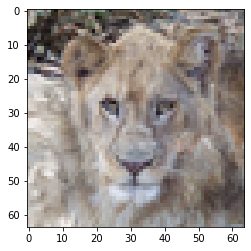

In [16]:
import numpy as np
import matplotlib.pyplot as plt

processed_images = (sampled_images * 255).permute(0, 2, 3, 1).cpu().numpy().astype(np.uint8)


plt.imshow(processed_images[0])
plt.show()

In [19]:
import clip

clip_model, _ = clip.load("ViT-L/14")
clip_model = clip_model.to(device)

In [20]:
texts = ["a white cat looking at the side", "a bulldog"]
text_tokens = clip.tokenize(texts).to(device)
text_embeds = clip_model.encode_text(text_tokens)




text embeds shape: torch.Size([2, 768])


100%|██████████| 1000/1000 [00:19<00:00, 50.44it/s, std=0.736]


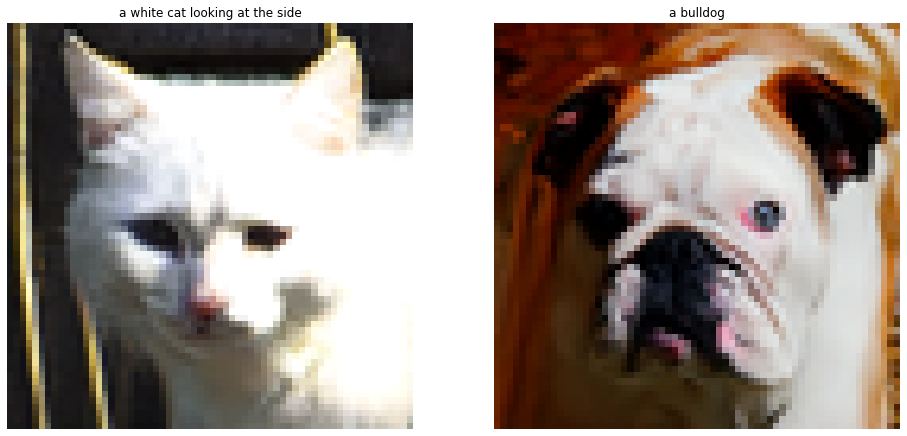

In [26]:
# text conditioning
print(f"text embeds shape: {text_embeds.shape}")
x_T = torch.randn(len(text_embeds), 3, 64, 64).to(device)
sampled_images = diffusion.sample(x_T, y=text_embeds, guidance_scale=3.0, seed=0)

processed_images = (sampled_images * 255).permute(0, 2, 3, 1).cpu().numpy().astype(np.uint8)
fig, axes = plt.subplots(1, len(processed_images), figsize=(8*len(processed_images), 8))
for i, ax in enumerate(axes):
    ax.imshow(processed_images[i])
    ax.set_title(texts[i])
    ax.axis('off')
plt.show()
